In [34]:
import pandas as pd #library for reading CSV file into memory

import pickle #library for saving data to disk.


import datetime #library for working with dates and times.
#from math import sin, cos, radians #import the math functions we need for calculating distance. Can delete this because we're using the numpy versions of these.
import numpy as np #library for working with matrices (similar to MATLAB)
import random #library for generating random numbers

import matplotlib #libary for graphing
import matplotlib.pyplot as plt #graphing
#from matplotlib.mlab import griddata 
from scipy.interpolate import griddata #interpolating data onto a grid

from ipywidgets import Layout

#set the size of the contour plot in the notebook.
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 20) # (w, h)

import os #loading/saving files, and working with path names.
import gdal #working with GeoTiff data to get elevation.

import simplekml #create google earth files from data

import folium #drawing maps.
from folium.plugins import HeatMap #drawing heat maps.


In [55]:
#set some parameters to be used throughtout the script.
analysis_date = datetime.datetime.now()
script_version = "1.0"
elevation_file = "CYOW_elevation.p"
data_filename =  "CYOW_data.p" #filename to save the probability data to
kmz_filename = "CYOW_Data.kmz"

#input data file
#this is the CSV file containing the source data from NAV Canada
filename = ["C:\\NAV_CAN_DB_Output\\YOW_May_2018.csv"]


#filter parameters
#the script will filter the source data to only include values within the paramters below
min_alt = 0
max_alt = 2000 #cutoff altitude for filtering the source data
max_lat =  45.75
min_lat =  45.0
max_lon = -74.83
min_lon = -76.58 #area around CYOW

#simulation parameters
grid_size = 100 #this sets the number of test points to be created across the area of interest in the lat and Long dimension
MAC_dist = 0.0329158 # = 200ft in nautical miles #how close does an aircraft need to be to be considered a MAC
MAC_alt = 2000# how high are we flying the drone?

Below are some functions we'll use for the analysis

#the function below takes the following as input:
- numpy_data: Input data with columns defined as latitude, longitude, altitude
- test_pos: a single location that is to be tested
- MAC_dist: the range threshold for an encounter to be considerd a mid-air collision

In [37]:
# this function takes a matrix of [lat,lon,alt] data, a test point, and a MAC distance. 
#it calculates the distance between each point in the matrix and the test point. 
#it counts how many records are closer to the test point than MAC distance
#it divides this count by the total number of records to give a probability that there will be a mid-air collision
#it returns the probability for that test point.
def numpy_distance(numpy_data, test_pos, MAC_dist, MAC_alt):
    
    lat1_rad = np.radians(numpy_data[:,0]) #convert all latitudes and longitudes to radians.
    lon1_rad = np.radians(numpy_data[:,1])
    lat2_rad = np.radians(test_pos[0])
    lon2_rad = np.radians(test_pos[1])
    
    #calculate the distance from every lat/long pair in numpy_data and the test_pos location
    dist_vect = ((180*60)/np.pi)*2*np.arcsin(np.add(np.sqrt(np.square(np.sin((lat1_rad - lat2_rad)/2))), 
                                                    np.cos(lat1_rad)*np.cos(lat2_rad)*(np.sqrt(np.square(np.sin((lon1_rad - lon2_rad)/2))))))
    
    alt_vect = numpy_data[:,2] - test_pos[2]
    #print(dist_vect.shape)
    #print(alt_vect.shape)
    MAC = np.logical_and(dist_vect <= MAC_dist, alt_vect <= MAC_alt) #get all aircraft below 700ft.
    #MAC = dist_vect <= MAC_dist #vector is "1" for all points where the aircraft is located closer than MAC_dist to the test point
    MAC = np.reshape(MAC, (-1,1))
    num_experiments = numpy_data.shape[0] #number of experiments is the number of records we have.
    number_of_MAC = np.count_nonzero(MAC) #number of times MAC is 1 is the number of mid air collisions we had.
    
    #probability of a mid-air collision is the number of MAC we counted divided by the total number of records
    probability = number_of_MAC / num_experiments
    return (probability)




In [38]:
#given a lat long, return the elevation at that location. 
#uses a folder of GEOTiff data as source data. 
def get_elevation(lat, lon):
    data_folder = 'C:\\Work Folder\\jupyter_notebooks\\NAV_Canada_data\\dted' #location of the GeoTiff Data
    index_file = data_folder + '\\file_index.p' #index file listing the lat/long extents of each GeoTiff file.
    index_list = pickle.load(open(index_file, "rb" ))
    
   #figure out which geotiff file holds the data we're looking for. 
    tif_file = False
    for file in index_list:
        min_lon, min_lat, max_lon, max_lat = file['corners']
        if min_lon < lon and min_lat < lat and max_lon > lon and max_lat > lat:
            tif_file = file['file']
    if(tif_file):
        #print(tif_file)
        #load the file and grab the elevation for that point

        driver = gdal.GetDriverByName('GTiff')
        dataset = gdal.Open(data_folder + '\\' + tif_file)
        band = dataset.GetRasterBand(1)
        cols = dataset.RasterXSize
        rows = dataset.RasterYSize
        transform = dataset.GetGeoTransform()

        xOrigin = transform[0]
        yOrigin = transform[3]
        pixelWidth = transform[1]
        pixelHeight = -transform[5]
        data = band.ReadAsArray(0, 0, cols, rows)

        col = int((lon - xOrigin) / pixelWidth)
        row = int((yOrigin - lat ) / pixelHeight)
        #print(col, row)
        elevation = data[row][col]
        elevation_ft = elevation * 3.28084 #convert meters to feet
        #print(row,col, elevation)
    else:
        elevation_ft = False #return false if we don't have data for that location
    return(elevation_ft)
    
  
lat = random.uniform(min_lat, max_lat)
lon = random.uniform(min_lon, max_lon)
lat = min_lat
lon = max_lon
print(lat, lon)
print(get_elevation(lat, lon))

45.0 -74.83
-107503.28427999999


In [39]:
#speed up getting the elevations by only opening each geotiff once.
def load_tiff_file(data_folder, tif_file):
    print(tif_file)
    #load the file and grab the elevation for that point

    driver = gdal.GetDriverByName('GTiff')
    dataset = gdal.Open(data_folder + '\\' + tif_file)
    band = dataset.GetRasterBand(1)
    cols = dataset.RasterXSize
    rows = dataset.RasterYSize
    transform = dataset.GetGeoTransform()

    xOrigin = transform[0]
    yOrigin = transform[3]
    pixelWidth = transform[1]
    pixelHeight = -transform[5]
    data = band.ReadAsArray(0, 0, cols, rows)
    
    out = (pixelWidth, pixelHeight, xOrigin, yOrigin, data)
    return(out)
    


def get_elevations(np_positions):
    data_folder = 'E:\\workspace\\nav_canada_data\\dted' #location of the GeoTiff Data
    index_file = data_folder + '\\file_index.p' #index file listing the lat/long extents of each GeoTiff file.
    index_list = pickle.load(open(index_file, "rb" ))
    
    print(np_positions.shape)
    np_elevations = np.zeros((np_positions.shape[0], 1))
    
    done_flag = False
    
    while(not done_flag):
        #grab the first point inthe np_positions list that doesn't have an elevation

        print("Number of missing elevations: %s"%np.nonzero(np_elevations == 0)[0].shape)
        first_missing_elevation = np.nonzero(np_elevations == 0)[0][0]
        test_lat = np_positions[first_missing_elevation][0]
        test_lon = np_positions[first_missing_elevation][1]
        print((test_lat, test_lon))

         #figure out which geotiff file holds the data we're looking for and load it
        tif_file = False
        for file in index_list:
            min_lon, min_lat, max_lon, max_lat = file['corners']
            if min_lon < test_lon and min_lat < test_lat and max_lon > test_lon and max_lat > test_lat:
                tif_file = file['file']
                corners = file['corners']
        if(tif_file):
            (pixelWidth, pixelHeight, xOrigin, yOrigin, data) = load_tiff_file(data_folder, tif_file)

            #find all locations within the input array that are on this tiff file we just loaded
            print(corners)

            #loop through our list of positions and grab the elevation data from the file we have open.
            for i, pos in enumerate(np_positions):
                #print(i, pos)
                test_lat = pos[0]
                test_lon = pos[1]
                if corners[0] < test_lon and corners[1] < test_lat and corners[2] > test_lon and corners[3] > test_lat:
                    #print(min_lat)
                    #print(pos_indices.shape)
                    col = int((test_lon - xOrigin) / pixelWidth)
                    row = int((yOrigin - test_lat ) / pixelHeight)
                    #print(col, row)
                    elevation = data[row][col]
                    elevation_ft = elevation * 3.28084 #convert meters to feet
                    #print(row,col, elevation)

                    #add the elevation to the np_elevations array
                    np_elevations[i] = elevation_ft
        #check to see if we're done:
        if np.nonzero(np_elevations == 0)[0].size == 0:
            #we're done
            done_flag = True
        print("Number of missing elevations: %d"%np.nonzero(np_elevations == 0)[0].shape)

    return(np_elevations)
    
    
#elevations = get_elevations(np_positions)
#print(elevations)

Load the NAV CANADA data from a CSV file. The block below does the following:
-Loads the data contained in the named CSV file. 
-Sets the minimum and maximum values of altitude and latitude/longitude to retain for analysis
-Parses the datestamp in the CSV file and turns it into a datetime object that we can use. 


In [40]:
#load the data
in_df = pd.read_csv(filename[0], engine = None, encoding = 'utf-8')
in_df.drop(in_df.tail(1).index,inplace=True) #delete the last line imported (seems to be corrupted in most CSV files)

print("Loaded...")
#Make sure the important colunms are floats:
in_df['FLIGHT_FIX_LONGITUDE_DEG'] = in_df.FLIGHT_FIX_LONGITUDE_DEG.astype(float)
print("Float Check done.")

print("Number of Records in the file: %d"%in_df.shape[0])
print("Filtering...")
#drop the rows that are outside our area of interest
in_df.drop(in_df[in_df.FLIGHT_FIX_LATITUDE_DEG <= min_lat].index, inplace=True)
in_df.drop(in_df[in_df.FLIGHT_FIX_LATITUDE_DEG > max_lat].index, inplace=True)
print("Latitude... done")
print("Number of Records remaining: %d"%in_df.shape[0])
in_df.drop(in_df[in_df.FLIGHT_FIX_LONGITUDE_DEG <= min_lon].index, inplace=True)
in_df.drop(in_df[in_df.FLIGHT_FIX_LONGITUDE_DEG > max_lon].index, inplace=True)
print("Longitude... done")
print("Number of Records remaining: %d"%in_df.shape[0])
in_df.drop(in_df[in_df.FLIGHT_FIX_ALTITUDE_ESTAB_FT <= min_alt].index, inplace=True)
in_df.drop(in_df[in_df.FLIGHT_FIX_ALTITUDE_ESTAB_FT > max_alt].index, inplace=True)
print("Altitude... done")
print("Number of Records remaining: %d"%in_df.shape[0])
print("Adding Datetime object")
in_df['datetime'] = pd.to_datetime(in_df['FLIGHT_EVENT_DATE'], format='%d-%b-%y %I.%M.%S.%f %p')
    
print("Number of Records remaining: %d"%in_df.shape[0])
print("Done.")    


Loaded...
Float Check done.
Number of Records in the file: 15927434
Filtering...
Latitude... done
Number of Records remaining: 10262300
Longitude... done
Number of Records remaining: 8460081
Altitude... done
Number of Records remaining: 2282787
Adding Datetime object
Number of Records remaining: 2282787
Done.


Convert the numbers we need in the pandas dataframe into numpy arrays  which we can math on much faster.


In [41]:
#create numpy arrays of the data we need.
np_positions = in_df[['FLIGHT_FIX_LATITUDE_DEG', 'FLIGHT_FIX_LONGITUDE_DEG', 'FLIGHT_FIX_ALTITUDE_ESTAB_FT']].values
np_times = (in_df[['datetime']].values.astype(np.int64)/1.0E9).astype(float)

In [42]:
#Delete the input dataframe to free up some RAM.
del in_df

In [10]:
#add elevation data to the test points.

#get the max and min latitude
#min_lat = np.amin(np_positions[:,0])
#max_lat = np.amax(np_positions[:,0])
#min_lon = np.amin(np_positions[:,1])
#max_lon = np.amax(np_positions[:,1])
bounds = (min_lat, max_lat, min_lon, max_lon)
print("Getting elevation data for the area bounded by: %s"%(bounds,))

#make a list of the lats and longs to check
lats = np.arange(min_lat, max_lat, (max_lat-min_lat)/grid_size)
lons = np.arange(min_lon, max_lon, (max_lon-min_lon)/grid_size)

#loop through all the grid points:
data_list = [] #list to hold the lat/long/elevation data
first_start = datetime.datetime.now()
for i, lat in enumerate(lats):
    start = datetime.datetime.now()
    print("Completed %d out of %d latitudes."%(i, lats.shape[0]))
    for j, lon in enumerate(lons):
        elevation = get_elevation(lat,lon) #Turn on the Geotiff Function
        #elevation = 0 #turn off the GEOTiff Function
        if elevation is not False: #GeoTiff data is available for that review
            if elevation > -100000: #elevation data will be -107503ft for areas outside canada
                #print((lat, lon, elevation))
                data_list.append((lat, lon, elevation))
        
        #data_list.append((lat, lon, number_MAC, number_experiments))
    end = datetime.datetime.now()
    delta = end - start
    print("Calculation took %s"%delta)
    percent_complete = (i+1)/(lats.shape[0]-1)
    time_so_far = end - first_start
    remaining_time = time_so_far / percent_complete * (1 - percent_complete)
    print("Time Remaining: %s"%remaining_time)
    
#print(len(data_list))
#print(data_list[0])
#test_point = data_list[0]

print("Saving Data to Elevation File")
pickle.dump(data_list, open(elevation_file, "wb" ))

Getting elevation data for the area bounded by: (45.0, 45.75, -76.58, -74.83)
Completed 0 out of 100 latitudes.
Calculation took 0:00:18.482964
Time Remaining: 0:30:11.330472
Completed 1 out of 100 latitudes.
Calculation took 0:00:15.797834
Time Remaining: 0:27:42.716333
Completed 2 out of 100 latitudes.
Calculation took 0:00:16.391709
Time Remaining: 0:27:01.584640
Completed 3 out of 100 latitudes.
Calculation took 0:00:16.025603
Time Remaining: 0:26:24.127921
Completed 4 out of 100 latitudes.
Calculation took 0:00:16.073658
Time Remaining: 0:25:56.147083
Completed 5 out of 100 latitudes.
Calculation took 0:00:15.628645
Time Remaining: 0:25:25.253041
Completed 6 out of 100 latitudes.
Calculation took 0:00:15.727631
Time Remaining: 0:25:00.008125
Completed 7 out of 100 latitudes.
Calculation took 0:00:16.072730
Time Remaining: 0:24:41.068032
Completed 8 out of 100 latitudes.
Calculation took 0:00:16.099637
Time Remaining: 0:24:23.034200
Completed 9 out of 100 latitudes.
Calculation too

Calculation took 0:00:15.519903
Time Remaining: 0:03:58.579805
Completed 84 out of 100 latitudes.
Calculation took 0:00:15.199132
Time Remaining: 0:03:42.558172
Completed 85 out of 100 latitudes.
Calculation took 0:00:15.458295
Time Remaining: 0:03:26.594842
Completed 86 out of 100 latitudes.
Calculation took 0:00:15.277675
Time Remaining: 0:03:10.618209
Completed 87 out of 100 latitudes.
Calculation took 0:00:15.511811
Time Remaining: 0:02:54.686728
Completed 88 out of 100 latitudes.
Calculation took 0:00:15.329285
Time Remaining: 0:02:38.744169
Completed 89 out of 100 latitudes.
Calculation took 0:00:15.687431
Time Remaining: 0:02:22.851054
Completed 90 out of 100 latitudes.
Calculation took 0:00:15.544852
Time Remaining: 0:02:06.949924
Completed 91 out of 100 latitudes.
Calculation took 0:00:15.414296
Time Remaining: 0:01:51.046607
Completed 92 out of 100 latitudes.
Calculation took 0:00:15.245462
Time Remaining: 0:01:35.143045
Completed 93 out of 100 latitudes.
Calculation took 0:0

In [43]:
data_list = pickle.load(open(elevation_file, "rb" ))

In [44]:
#check how many points were retained in the data_list:
print("Test Point List contains %d points."%len(data_list))
print(data_list[0:500])

Test Point List contains 9997 points.
[(45.0, -76.58, 816.92916), (45.0, -76.5625, 800.52496), (45.0, -76.545, 721.7848), (45.0, -76.5275, 692.25724), (45.0, -76.51, 708.66144), (45.0, -76.4925, 623.3596), (45.0, -76.47500000000001, 633.20212), (45.0, -76.45750000000001, 524.9344), (45.0, -76.44000000000001, 626.64044), (45.0, -76.42250000000001, 623.3596), (45.0, -76.40500000000002, 593.83204), (45.0, -76.38750000000002, 501.96852), (45.0, -76.37000000000002, 498.68768), (45.0, -76.35250000000002, 475.7218), (45.0, -76.33500000000002, 459.31759999999997), (45.0, -76.31750000000002, 534.77692), (45.0, -76.30000000000003, 495.40684), (45.0, -76.28250000000003, 492.126), (45.0, -76.26500000000003, 482.28348), (45.0, -76.24750000000003, 462.59844), (45.0, -76.23000000000003, 465.87928), (45.0, -76.21250000000003, 459.31759999999997), (45.0, -76.19500000000004, 475.7218), (45.0, -76.17750000000004, 472.44096), (45.0, -76.16000000000004, 452.75592), (45.0, -76.14250000000004, 442.9134), (45

In [47]:
#take the list of points created above, and run it through the NAV Canada data... checking the probability of a mid air
#collision for each data point

first_start = datetime.datetime.now()
prob_data = [] #list to hold probability data
for i, point in enumerate(data_list):
    start = datetime.datetime.now()
    
    probability = numpy_distance(np_positions, (point[0], point[1], point[2]), MAC_dist, MAC_alt)
    
    prob_data.append((point[0], point[1], probability))
    end = datetime.datetime.now()
    delta = end - start
    if i%100 == 0: #print status every 100 points
        print("Tested %d out of %d points."%(i, len(data_list)))
        percent_complete = (i+1)/(len(data_list)-1)
        time_so_far = end - first_start
        remaining_time = time_so_far / percent_complete * (1 - percent_complete)
        print("Time Remaining: %s"%remaining_time)
    
#save the file. 
pickle.dump(prob_data, open(data_filename, "wb" ))

Tested 0 out of 9997 points.
Time Remaining: 0:35:53.142890
Tested 100 out of 9997 points.
Time Remaining: 0:28:06.523002
Tested 200 out of 9997 points.
Time Remaining: 0:27:40.760573
Tested 300 out of 9997 points.
Time Remaining: 0:27:28.517250
Tested 400 out of 9997 points.
Time Remaining: 0:27:23.700475
Tested 500 out of 9997 points.
Time Remaining: 0:27:10.738371
Tested 600 out of 9997 points.
Time Remaining: 0:26:53.360580
Tested 700 out of 9997 points.
Time Remaining: 0:26:35.808840
Tested 800 out of 9997 points.
Time Remaining: 0:26:15.703930
Tested 900 out of 9997 points.
Time Remaining: 0:25:56.743848
Tested 1000 out of 9997 points.
Time Remaining: 0:25:40.674105
Tested 1100 out of 9997 points.
Time Remaining: 0:25:22.090328
Tested 1200 out of 9997 points.
Time Remaining: 0:25:07.903050
Tested 1300 out of 9997 points.
Time Remaining: 0:24:51.161122
Tested 1400 out of 9997 points.
Time Remaining: 0:24:40.925794
Tested 1500 out of 9997 points.
Time Remaining: 0:24:47.924854
Test

In [14]:
#load the data (if we didn't just create the data)
prob_data = pickle.load(open(data_filename, "rb" ))

In [48]:
#create a nx3 numpy array [lat, lon, probability]
locations = np.array(prob_data)
print("Array dimentions are: %s"%(locations.shape,))
print(locations[5000:5025])
#heatmap_data = np.array(locations[:,[0,1]])
#heatmap_data = np.c_[heatmap_data, probability]

Array dimentions are: (9997, 3)
[[ 45.375  -76.5275   0.    ]
 [ 45.375  -76.51     0.    ]
 [ 45.375  -76.4925   0.    ]
 [ 45.375  -76.475    0.    ]
 [ 45.375  -76.4575   0.    ]
 [ 45.375  -76.44     0.    ]
 [ 45.375  -76.4225   0.    ]
 [ 45.375  -76.405    0.    ]
 [ 45.375  -76.3875   0.    ]
 [ 45.375  -76.37     0.    ]
 [ 45.375  -76.3525   0.    ]
 [ 45.375  -76.335    0.    ]
 [ 45.375  -76.3175   0.    ]
 [ 45.375  -76.3      0.    ]
 [ 45.375  -76.2825   0.    ]
 [ 45.375  -76.265    0.    ]
 [ 45.375  -76.2475   0.    ]
 [ 45.375  -76.23     0.    ]
 [ 45.375  -76.2125   0.    ]
 [ 45.375  -76.195    0.    ]
 [ 45.375  -76.1775   0.    ]
 [ 45.375  -76.16     0.    ]
 [ 45.375  -76.1425   0.    ]
 [ 45.375  -76.125    0.    ]
 [ 45.375  -76.1075   0.    ]]


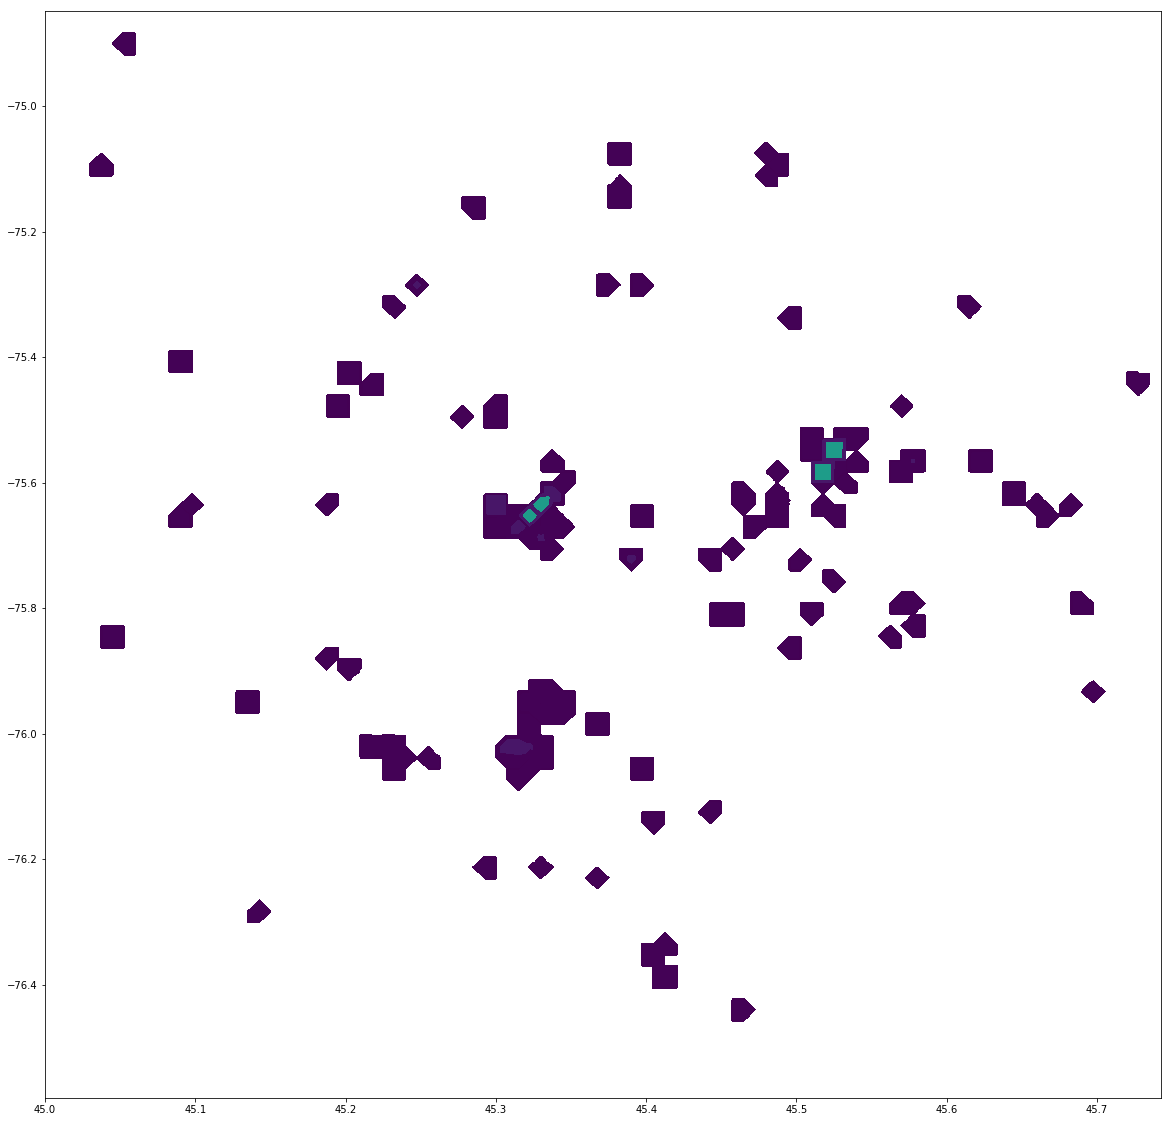

In [49]:
#make a contour plot of the data
#we'll then extract the contour lines from this plot in order to draw the google earth map. 

#get the max and minimum latitude and longitude points
min_lat = np.min(locations[:,0])
max_lat = np.max(locations[:,0])
min_lon = np.min(locations[:,1])
max_lon = np.max(locations[:,1])

#create a vector of lats and longs, and then make a mesh for plotting
lats = np.linspace(min_lat, max_lat, 1000)
lons = np.linspace(min_lon, max_lon, 1000)
lati, loni = np.meshgrid(lats,lons)


#interpolate the probability for all of the intermediate points.
probi = griddata((locations[:,0], locations[:,1]), locations[:,2], (lati, loni), method = 'linear')


#print(lati.shape)
#print(loni.shape)
#print(probi.shape)

#print(lat1.shape)




#set the probability levels we want to plot.
levels = np.array([0, 10**-9, 10**-7, 10**-5, 10**-4, 10**-3])


c = plt.contourf(lati, loni, probi, levels);


In [50]:
def get_contour_verts(cn):
    contours = []
    # for each contour line
    for cc in cn.collections:
        paths = []
        # for each separate section of the contour line
        for pp in cc.get_paths():
            xy = []
            polygon = pp.to_polygons()
            #print(polygon[0].shape)
            for point in polygon[0]:
                point_tuple = (point[0],point[1])
                #print(point_tuple)
                xy.append(point_tuple)
            #print(xy)
            paths.append(xy)
        contours.append(paths)
            

    return contours

conts = get_contour_verts(c)
#print(conts)

In [24]:
print(len(conts))

5


In [51]:
for cont in conts:
    print(len(cont))
    

70
71
82
9
4


In [52]:
print(levels)

[0.e+00 1.e-09 1.e-07 1.e-05 1.e-04 1.e-03]


In [53]:
colours = ['00000000',
           simplekml.Color.changealphaint(200, simplekml.Color.green),
           simplekml.Color.changealphaint(200, simplekml.Color.yellow),
           simplekml.Color.changealphaint(200, simplekml.Color.orange),
           simplekml.Color.changealphaint(200, simplekml.Color.red)]

In [54]:
#build the description string for the kml file:
description_string = "KML File created: %s"%analysis_date.strftime('%b %d, %Y')
description_string += "\n\nScript Version: %s"%script_version
description_string += "\n\nSource Data File: %s"%filename[0].split('\\')[-1]
description_string += "\n\nAltitude Range: %dft - %dft"%(min_alt, max_alt)
print(description_string)

print(description_string)



kml = simplekml.Kml()
kml.document.description = description_string
for cont in zip(conts, colours, levels):
    #print(cont[1])
    fol = kml.newfolder(name=str(cont[2]))
    for i, poly, in enumerate(cont[0]):
        rev = [t[::-1] for t in poly]
        pol = fol.newpolygon(name=str(i),
                             outerboundaryis=rev,
                             description = 'Probability of MAC: %s'%str(cont[2]))
        #pol.style.polystyle.color = simplekml.Color.changealphaint(200, cont[1])
        pol.style.polystyle.color = cont[1]
#print(kml.kml())
kml.savekmz(kmz_filename)

KML File created: Nov 18, 2020

Script Version: 1.0

Source Data File: YOW_May_2018.csv

Altitude Range: 0ft - 2000ft
KML File created: Nov 18, 2020

Script Version: 1.0

Source Data File: YOW_May_2018.csv

Altitude Range: 0ft - 2000ft
